<a href="https://colab.research.google.com/github/gtsagkatakis/OptimizationMethods_2023/blob/main/HY530_TensorDecomposition_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Denoising with PCA, SVD and Tucker decomposition
## Introduction
The objective is to denoise hyperspectrall data either by transforming them to matrices and applying PCA or SVD, or by maintaining the 3D structure and performing Tucker decomposition of the 3D tensor

## Step 1: Import Libraries
Let's begin by importing the necessary libraries and loading the dataset. It might take some time, be patient :)


In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
!pip install tensorly torch

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat



import tensorly as tl
from tensorly.decomposition import parafac
tl.set_backend('pytorch')


(610, 340, 103)


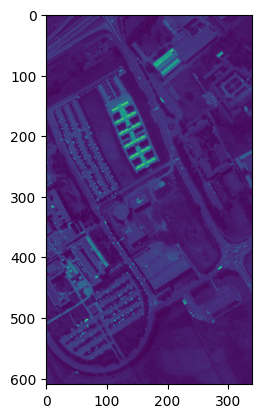

In [56]:
X = loadmat('/content/drive/MyDrive/CSD573_2023/PaviaU.mat')['paviaU']

plt.imshow(X[:,:,10])
print(X.shape)

##Step 3: Data Preprocessing
Before applying PCA, let's select a single image from the dataset, standardize it and add some more noise.

In [57]:
n1, n2, n3 = X.shape
X_2d = X.reshape(n1*n2, n3)

In [58]:
# Standardize the data
X_2d_mean=np.mean(X_2d)
X_2d_std=np.std(X_2d)
X_2d = (X_2d - X_2d_mean) /X_2d_std

# Define the standard deviation of the Gaussian noise
noise_stddev = 0.5  # You can adjust this value

# Generate Gaussian noise with the same shape as the image
noise = np.random.normal(0, noise_stddev, X_2d.shape)

# Add the noise to the image
Y_2d = X_2d + noise

Y=Y_2d.reshape(n1, n2, n3)

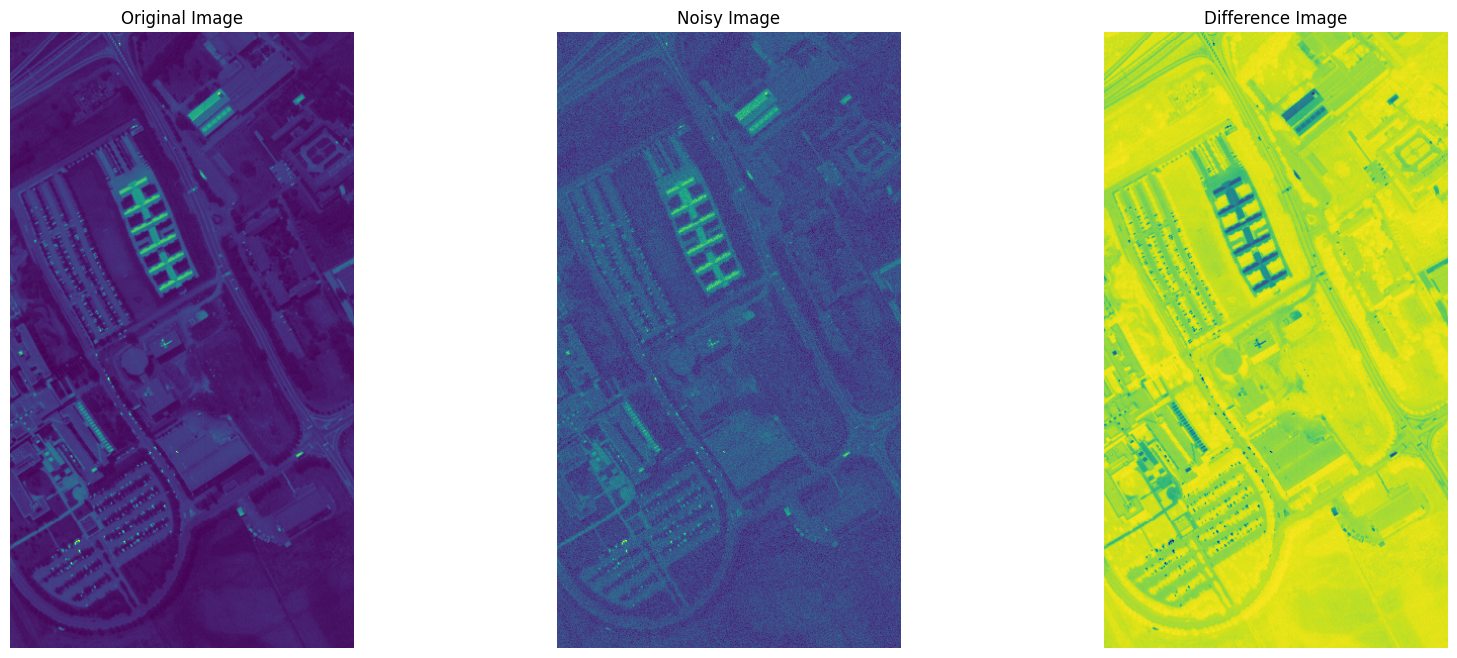

In [59]:
# Display the noisy and original images
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
axes[0].imshow(X[:,:,10], cmap='viridis')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(Y[:,:,10], cmap='viridis')
axes[1].set_title('Noisy Image')
axes[1].axis('off')

axes[2].imshow(Y[:,:,10]-X[:,:,10], cmap='viridis')
axes[2].set_title('Difference Image')
axes[2].axis('off')

plt.show()

##Step 4: Define the PCA function
PCA is primarily used as a technique for dimensionality reduction. It identifies a set of orthogonal principal components (eigenvectors of the covariance matrix) that capture the most significant variations in the data. These principal components can be used to represent the data in a lower-dimensional space.

In [60]:
import numpy as np

def custom_pca(data, num_components=None):
    """
    Perform Principal Component Analysis (PCA) on the given data.

    Parameters:
    - data: The input data matrix with samples in rows and features in columns.
    - num_components: The number of principal components to retain. If None, all components are retained.

    Returns:
    - components: The principal components.
    - explained_variance: The explained variance of each principal component.
    - mean: The mean of the input data.
    """
    # Calculate the mean of the data
    mean = np.mean(data, axis=0)

    # Center the data by subtracting the mean
    centered_data = data - mean

    # Calculate the covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Retain only the specified number of principal components
    if num_components is not None:
        components = eigenvectors[:, :num_components]
        explained_variance = eigenvalues[:num_components] / np.sum(eigenvalues)
    else:
        components = eigenvectors
        explained_variance = eigenvalues / np.sum(eigenvalues)

    return components, explained_variance, mean


##Step 1: Define the SVD function

In [61]:
def custom_svd(matrix):
    """
    Perform Singular Value Decomposition (SVD) on the given matrix.

    Parameters:
    - matrix: The input matrix to decompose.

    Returns:
    - U: The left singular vectors.
    - S: The singular values.
    - Vt: The transpose of the right singular vectors.
    """
    # Calculate the covariance matrix
    covariance_matrix = np.dot(matrix.T, matrix)

    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Calculate the singular values and U matrix
    singular_values = np.sqrt(eigenvalues)
    U = eigenvectors

    # Calculate the Vt matrix
    Vt = np.dot(np.linalg.inv(np.diag(singular_values)), np.dot(U.T, matrix.T))

    return U, singular_values, Vt

## Application of PCA and SVD


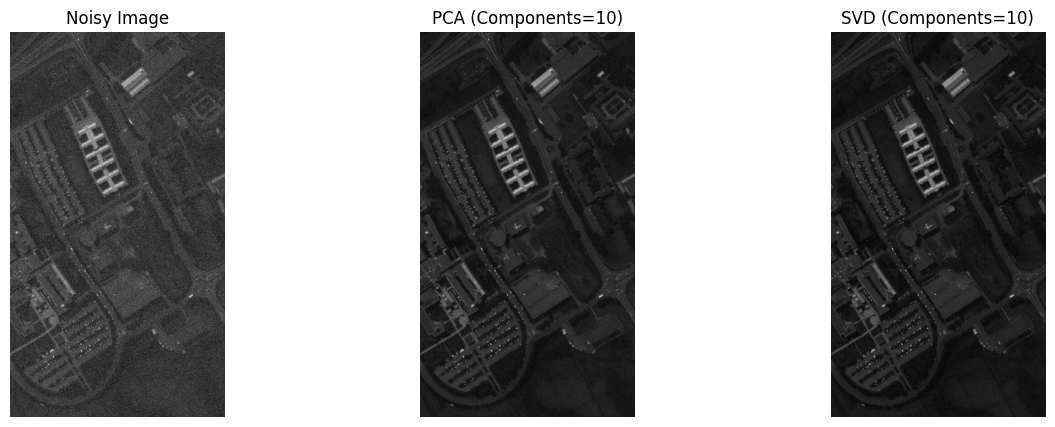

In [68]:
# Choose a number of components for comparison
n_components_comparison = 10  # You can adjust this value

# Perform PCA with the selected number of components on the noisy image
pca = PCA(n_components=n_components_comparison)
image_data_compressed_pca = pca.fit_transform(Y_2d)
image_data_reconstructed_pca_2d = pca.inverse_transform(image_data_compressed_pca)
image_data_reconstructed_pca = image_data_reconstructed_pca_2d.reshape(n1,n2,n3)

# Perform SVD with the selected number of components on the noisy image
U, sigma, VT = custom_svd(Y_2d)
reconstructed_img_svd_2d = np.dot(U[:, :n_components_comparison], np.dot(np.diag(sigma[:n_components_comparison]), VT[:n_components_comparison, :]))
reconstructed_img_svd_2d=reconstructed_img_svd_2d.T
reconstructed_img_svd = reconstructed_img_svd_2d.reshape(n1,n2,n3)

# Create subplots for PCA, SVD, and the noisy image comparisons
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(Y[:,:,10], cmap='gray')
axes[0].set_title('Noisy Image')
axes[0].axis('off')
axes[1].imshow(image_data_reconstructed_pca[:,:,10], cmap='gray')
axes[1].set_title(f'PCA (Components={n_components_comparison})')
axes[1].axis('off')
axes[2].imshow(reconstructed_img_svd[:,:,10], cmap='gray')
axes[2].set_title(f'SVD (Components={n_components_comparison})')
axes[2].axis('off')
plt.show()

In [69]:
mse_pca = np.linalg.norm(image_data_reconstructed_pca-X)/np.linalg.norm(X)
mse_svd = np.linalg.norm(reconstructed_img_svd-X)/np.linalg.norm(X)

print('mse_pca',mse_pca,'mse_svd',mse_svd)


mse_pca 0.999663021995838 mse_svd 0.9996628560682507


In [70]:
from tensorly.decomposition import tucker
X = X.astype(np.float32)
tensor_gpu = tl.tensor(X).cuda()

In [71]:
tucker_rank = [n1, n2, n_components_comparison]
core, tucker_factors = tucker(tensor_gpu, rank=tucker_rank, init='random', tol=10e-5)
tucker_reconstruction = tl.tenalg.multi_mode_dot(core, tucker_factors).cpu().numpy()


In [66]:
mse_tucker = np.linalg.norm(tucker_reconstruction-X)/np.linalg.norm(X)

print('mse_pca',mse_pca,'mse_svd',mse_svd,'mse_tucker',mse_tucker)

mse_pca 0.9996734311069883 mse_svd 0.999673431760583 mse_tucker 0.035257056


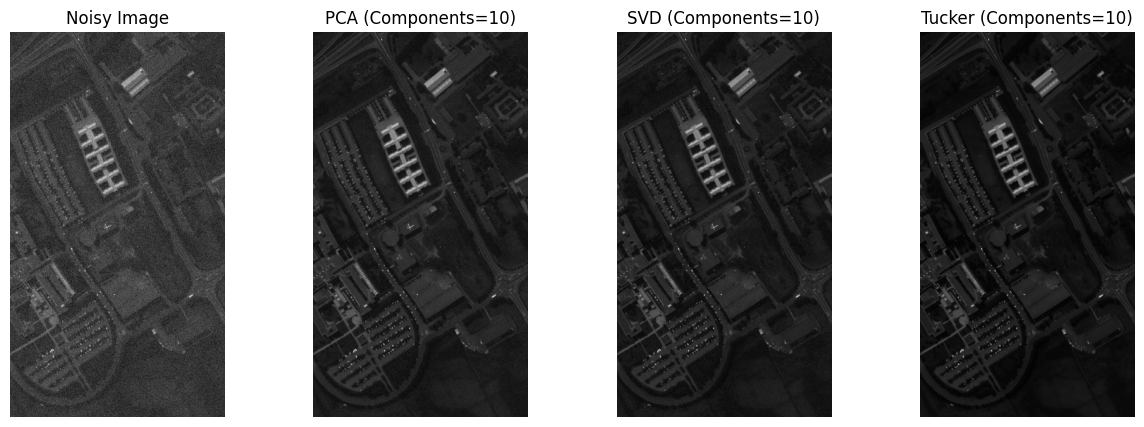

In [72]:
# Create subplots for PCA, SVD, Tucker, and the noisy image comparisons
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(Y[:,:,10], cmap='gray')
axes[0].set_title('Noisy Image')
axes[0].axis('off')
axes[1].imshow(image_data_reconstructed_pca[:,:,10], cmap='gray')
axes[1].set_title(f'PCA (Components={n_components_comparison})')
axes[1].axis('off')
axes[2].imshow(reconstructed_img_svd[:,:,10], cmap='gray')
axes[2].set_title(f'SVD (Components={n_components_comparison})')
axes[2].axis('off')
axes[3].imshow(tucker_reconstruction[:,:,10], cmap='gray')
axes[3].set_title(f'Tucker (Components={n_components_comparison})')
axes[3].axis('off')
plt.show()

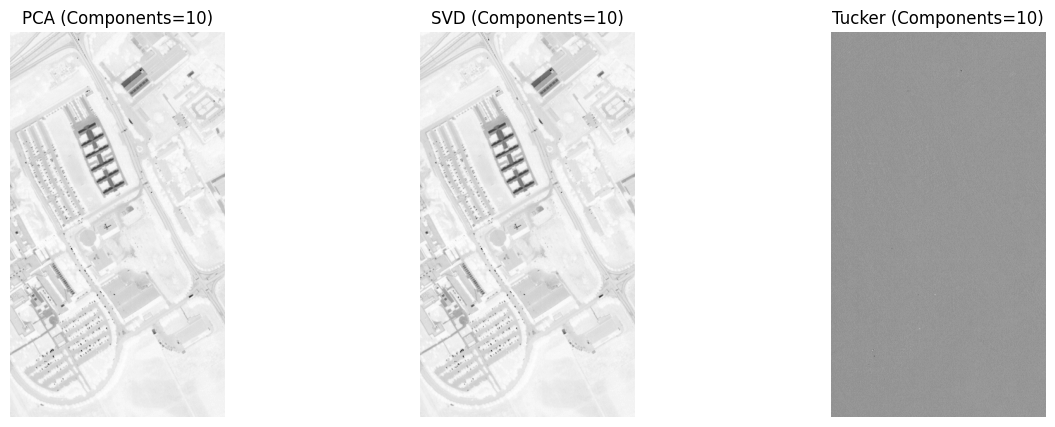

In [74]:
# Create subplots for Diffefence of PCA, SVD, and Tucker
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_data_reconstructed_pca[:,:,10]-X[:,:,10], cmap='gray')
axes[0].set_title(f'PCA (Components={n_components_comparison})')
axes[0].axis('off')
axes[1].imshow(reconstructed_img_svd[:,:,10]-X[:,:,10], cmap='gray')
axes[1].set_title(f'SVD (Components={n_components_comparison})')
axes[1].axis('off')
axes[2].imshow(tucker_reconstruction[:,:,10]-X[:,:,10], cmap='gray')
axes[2].set_title(f'Tucker (Components={n_components_comparison})')
axes[2].axis('off')
plt.show()